In [105]:
import tensorflow as tf
import numpy as np
import glob
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import ZeroPadding2D
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [106]:
path = "../../../../../../../Volumes/T7 Shield/exp_1_interpolated_numpy"

# Get sorted file lists
feature_files = sorted(glob.glob(f"{path}/*_features.npy"))
target_files = sorted(glob.glob(f"{path}/*_targets.npy"))

# Generate indices and shuffle
indices = np.arange(len(feature_files))
np.random.shuffle(indices)

test_idx = indices[0]
remaining_idx = indices[1:]
train_split = int(0.85 * len(remaining_idx))
train_idx = remaining_idx[:train_split]
val_idx = remaining_idx[train_split:]


# Create datasets
train_features = [feature_files[i] for i in train_idx]
train_targets = [target_files[i] for i in train_idx]

val_features = [feature_files[i] for i in val_idx]
val_targets = [target_files[i] for i in val_idx]

test_features = [feature_files[test_idx]]
test_targets = [target_files[test_idx]]

In [107]:
class LazyLoadDataset(tf.data.Dataset):
    def __new__(cls, input_files, target_files, batch_size=1):
        # Convert lists to TensorFlow datasets
        input_ds = tf.data.Dataset.from_tensor_slices(input_files)
        target_ds = tf.data.Dataset.from_tensor_slices(target_files)

        # Load NumPy files dynamically
        def load_numpy(input_path, target_path):
            x = np.load(input_path.numpy())
            y = np.load(target_path.numpy())
            y = y[:,:,3] # select co2flux_pre

            return x, y

        def load_numpy_tf(input_path, target_path):
            # Use tf.py_function to wrap the numpy loading
            x, y = tf.py_function(load_numpy, [input_path, target_path], [tf.float32, tf.float32])

            x.set_shape([150, 360, 15])
            y.set_shape([150, 360])

            return x, y

        # Zip the datasets & apply loading function
        dataset = tf.data.Dataset.zip((input_ds, target_ds))
        dataset = dataset.map(load_numpy_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Batch, shuffle, and prefetch
        dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [ ]:
batch_size = 16
train_dataset = LazyLoadDataset(train_features, train_targets, batch_size)
val_dataset = LazyLoadDataset(val_features, val_targets)
test_dataset = LazyLoadDataset(test_features, test_targets)


In [109]:
lr = 0.0001
loss_function = 'mse'

bias_initializer = tf.keras.initializers.Constant(150)

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u1 = UpSampling2D((2, 2))(bn)
    u1 = Conv2D(128, (2, 2), activation='relu', padding='same')(u1)
    u1_padded = ZeroPadding2D(((1, 0), (0, 0)))(u1)  
    m1 = concatenate([u1_padded, c3])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(m1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Conv2D(64, (2, 2), activation='relu', padding='same')(u2)
    u2_padded = ZeroPadding2D(((1, 0), (0, 0)))(u2)  
    m2 = concatenate([u2_padded, c2])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(m2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u3 = UpSampling2D((2, 2))(c5)
    u3 = Conv2D(32, (2, 2), activation='relu', padding='same')(u3)
    m3 = concatenate([u3, c1])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(m3)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    # Output
    outputs = Conv2D(1, (1, 1), activation='linear')(c6)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = unet_model((150, 360, 15))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function, metrics=['mae'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 150, 360,  │          0 │ -                 │
│ (InputLayer)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 150, 360,  │      4,352 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 150, 360,  │      9,248 │ conv2d_126[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 75, 180,   │          0 │ conv2d_127[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 75, 180,   │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 75, 180,   │     36,928 │ conv2d_128[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 37, 90,    │          0 │ conv2d_129[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 37, 90,    │     73,856 │ max_pooling2d_22… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 37, 90,    │    147,584 │ conv2d_130[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 18, 45,    │          0 │ conv2d_131[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 18, 45,    │    295,168 │ max_pooling2d_23… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 18, 45,    │    590,080 │ conv2d_132[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 36, 90,    │          0 │ conv2d_133[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 36, 90,    │    131,200 │ up_sampling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_14   │ (None, 37, 90,    │          0 │ conv2d_134[0][0]  │
│ (ZeroPadding2D)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 37, 90,    │          0 │ zero_padding2d_1… │
│ (Concatenate)       │ 256)              │            │ conv2d_131[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 37, 90,    │    295,040 │ concatenate_21[0

 Total params: 1,929,057 (7.36 MB)

 Trainable params: 1,929,057 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=5,  # Number of training epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 155s 971ms/step - loss: 2.4163 - mae: 1.0347 - val_loss: 0.8313 - val_mae: 0.5903
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 969ms/step - loss: 0.8387 - mae: 0.5983 - val_loss: 0.7103 - val_mae: 0.5333
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 969ms/step - loss: 0.7353 - mae: 0.5519 - val_loss: 0.6233 - val_mae: 0.4935
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 970ms/step - loss: 0.6483 - mae: 0.5104 - val_loss: 0.5614 - val_mae: 0.4667
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 971ms/step - loss: 0.5541 - mae: 0.4592 - val_loss: 0.4861 - val_mae: 0.4302


In [111]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.4178 - mae: 0.4102
Test Loss: 0.41776320338249207, Test MAE: 0.410153865814209


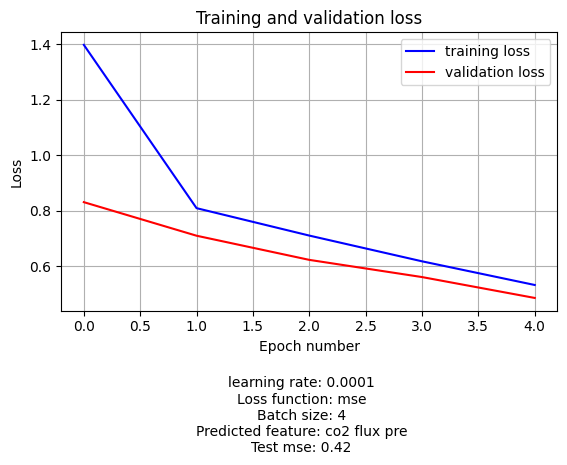

In [ ]:
from datetime import datetime


plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: co2 flux pre\nTest mse: {test_loss:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/u-net-interpolated/flux/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [ ]:
def plotAbsolute_numpy(data, vmin=100, vmax=400, lat_min= -74.5, lat_max=74.5):
    # Define map boundaries

    lon_min, lon_max = -179.5, 179.5

    # Create a grid
    num_lat, num_lon = 150, 360  # Grid resolution
    lat_grid = np.linspace(lat_min, lat_max, num_lat)
    lon_grid = np.linspace(lon_min, lon_max, num_lon)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize Basemap
    m = Basemap(projection='cyl',
                llcrnrlat=-74.5, urcrnrlat=74.5,
                llcrnrlon=-179.5, urcrnrlon=179.5,
                resolution='c')

    plt.figure(figsize=(18, 8))
    m.fillcontinents(color='black')

    # Plot data on the map
    x, y = m(lon_grid, lat_grid)
    pcm = m.pcolormesh(x, y, data[:,:,3], vmin=vmin, vmax=vmax, cmap='coolwarm', shading='auto')
    m.fillcontinents(color='black')

    # Add colorbar
    cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
    cbar.set_label('Pre-industrial CO2 Flux')

    plt.title("Pre-industrial CO2 Flux")
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
    path = '../plots/u-net-interpolated/flux/' + timestamp + '_pae_map.png'
    plt.savefig(path, format='png', dpi=300,  bbox_inches='tight') 
    plt.close()

def plotMaeInPercent(data, vmax = 10):
    # Define map boundaries

    lat_min= -74.5
    lat_max=74.5
    lon_min, lon_max = -179.5, 179.5

    # Create a grid
    num_lat, num_lon = 150, 360  # Grid resolution
    lat_grid = np.linspace(lat_min, lat_max, num_lat)
    lon_grid = np.linspace(lon_min, lon_max, num_lon)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize Basemap
    m = Basemap(projection='cyl',
                llcrnrlat=-74.5, urcrnrlat=74.5,
                llcrnrlon=-179.5, urcrnrlon=179.5,
                resolution='c')

    plt.figure(figsize=(18, 8))
    m.fillcontinents(color='black')

    maeP = (abs(data[:,:,3]-data[:,:,2]))/data[:,:,2]*100

    # Plot data on the map
    x, y = m(lon_grid, lat_grid)
    pcm = m.pcolormesh(x, y, maeP, vmin=0, vmax=vmax, cmap='coolwarm', shading='auto')
    m.fillcontinents(color='black')

    # Add colorbar
    cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
    cbar.set_label('Pre-industrial CO2 Flux error in percent')

    plt.title("Pre-industrial CO2 Flux error in percent")
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
    path = '../plots/u-net-interpolated/flux/' + timestamp + '_pae_' + str(vmax) + '_map.png'
    plt.savefig(path, format='png', dpi=300,  bbox_inches='tight') 
    plt.close()

In [114]:
import joblib

path = "../../../../../../../Volumes/T7 Shield/exp_1_interpolated_numpy/"
x = np.load(path + '1959_1_features.npy')
y = np.load(path + '1959_1_targets.npy')
y = y[:,:,3]

x = np.expand_dims(x, axis=0)
pred = model.predict(x)

lats_longs = x[:,:,:,13:15].reshape(150, 360, 2)
pred = pred.reshape(150, 360, 1)
y = np.expand_dims(y, axis=-1)

stacked_array = np.concatenate([lats_longs, y, pred], axis=-1)
# plotAbsolute_numpy(stacked_array)
plotMaeInPercent(stacked_array,50)
plotMaeInPercent(stacked_array,20)
plotMaeInPercent(stacked_array,10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


/var/folders/ns/4sxfm4t95836d2h_1wgqvzdh0000gn/T/ipykernel_77064/2440076991.py:58: RuntimeWarning: divide by zero encountered in divide
  maeP = (abs(data[:,:,3]-data[:,:,2]))/data[:,:,2]*100
